In [13]:
!pip install torchvision

Transferring the style of oilPainting to initial image joker
The style transfered : 185.737213 Loss of style in Initial image: 28.076725

The style transfered : 64.202774 Loss of style in Initial image: 29.485435

The style transfered : 36.883167 Loss of style in Initial image: 28.118992

The style transfered : 26.069756 Loss of style in Initial image: 26.648788

The style transfered : 20.530504 Loss of style in Initial image: 25.337996

The style transfered : 17.180313 Loss of style in Initial image: 24.351068

Saved stylized image: C:\Users\Komal\Desktop\numpy\Aries\output\joker_oilPainting.jpg


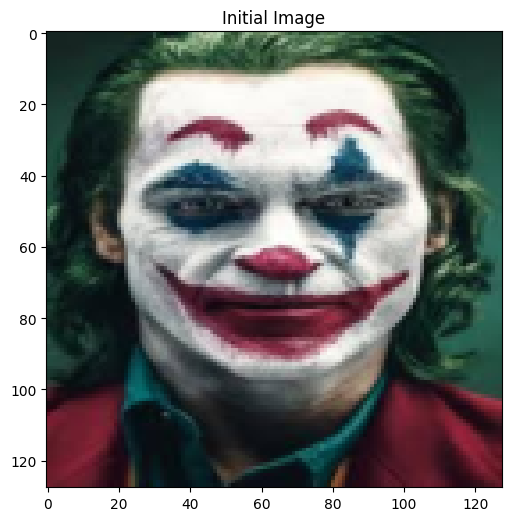

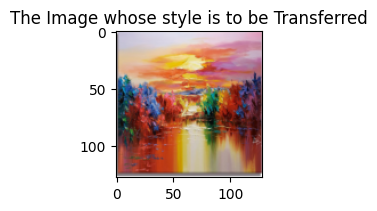

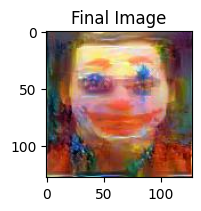

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 512 if torch.cuda.is_available() else 128
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

def load_image(image_path, size=None):
    image = Image.open(image_path)
    if size is not None:
        image = transforms.Resize(size)(image)
    image = transform(image).unsqueeze(0)
    return image.to(device)

def get_image_size(image):
    return image.shape[2], image.shape[3]

def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

class StyleTransfer(nn.Module):
    def __init__(self, cnn, normalization_mean, normalization_std, initial_image, style_image, initial_layers=None, style_layers=None):
        super(StyleTransfer, self).__init__()
        self.cnn = copy.deepcopy(cnn)
        self.normalization = Normalization(normalization_mean, normalization_std).to(device)

        if initial_layers is None:
            initial_layers = ['conv_4']
        if style_layers is None:
            style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

        self.initial_layers = initial_layers
        self.style_layers = style_layers

        self.model, self.initial_losses, self.style_losses = self.get_model_and_losses(initial_image, style_image)

    def get_model_and_losses(self, initial_image, style_image):
        initial_losses = []
        style_losses = []
        model = nn.Sequential(self.normalization)
        i = 0

        for layer in self.cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            else:
                raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

            model.add_module(name, layer)

            if name in self.initial_layers:
                target = model(initial_image).detach()
                initial_loss = InitialLoss(target)
                model.add_module(f"initial_loss_{i}", initial_loss)
                initial_losses.append(initial_loss)

            if name in self.style_layers:
                target_feature = model(style_image).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module(f"style_loss_{i}", style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], InitialLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, initial_losses, style_losses

    @staticmethod
    def gram_matrix(input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

class InitialLoss(nn.Module):
    def __init__(self, target):
        super(InitialLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = StyleTransfer.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = StyleTransfer.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(style_transfer, input_img, num_steps=300, style_weight=1000000, initial_weight=1):
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            style_transfer.model(input_img)
            style_score = 0
            initial_score = 0

            for sl in style_transfer.style_losses:
                style_score += sl.loss
            for cl in style_transfer.initial_losses:
                initial_score += cl.loss

            style_score *= style_weight
            initial_score *= initial_weight

            loss = style_score + initial_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'The style transfered : {style_score.item():4f} Loss of style in Initial image: {initial_score.item():4f}')
                print()

            return loss

        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img


cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

working_dir = os.getcwd()
initial_dir = os.path.join(working_dir, "initial")
style_dir = os.path.join(working_dir, "style")
output_dir = os.path.join(working_dir, "output")
os.makedirs(output_dir, exist_ok=True)

initial_images = ["joker.jpg"]
style_images = ["oilPainting.jpg"]  

# Perform style transfer for each pair of content and style images
for initial_image_name in initial_images:
    for style_image_name in style_images:
        initial_image_path = os.path.join(initial_dir, initial_image_name)
        style_image_path = os.path.join(style_dir, style_image_name)
        output_image_name = f"{os.path.splitext(initial_image_name)[0]}_{os.path.splitext(style_image_name)[0]}.jpg"
        print("Transferring the style of", os.path.splitext(style_image_name)[0], "to initial image", os.path.splitext(initial_image_name)[0])
        initial_image = load_image(initial_image_path)
        style_image = load_image(style_image_path, get_image_size(initial_image))

        style_transfer = StyleTransfer(cnn, cnn_normalization_mean, cnn_normalization_std, initial_image, style_image)

        input_image = initial_image.clone()

        output_image = run_style_transfer(style_transfer, input_image)
        output_image_path = os.path.join(output_dir, output_image_name)
        output_image_pil = transforms.ToPILImage()(output_image.squeeze(0).cpu())
        output_image_pil.save(output_image_path)

        print(f"Saved stylized image: {output_image_path}")

# Display the styled image
for initial_image_name in initial_images:
    initial_image_path = os.path.join(initial_dir, initial_image_name)
    initial_image = load_image(initial_image_path)
    
    plt.figure(figsize=(20, 10 * len(style_images)))
    
    for idx, style_image_name in enumerate(style_images, start=1):
        style_image_path = os.path.join(style_dir, style_image_name)
        style_image = load_image(style_image_path, get_image_size(initial_image))
        output_image_name = f"{os.path.splitext(initial_image_name)[0]}_{os.path.splitext(style_image_name)[0]}.jpg"
        output_image_path = os.path.join(output_dir, output_image_name)
        output_image = load_image(output_image_path)  
        row_index = (idx - 1) * 3
        
        plt.subplot(len(style_images), 3, row_index + 1)
        imshow(initial_image, title='Initial Image')
        
        plt.subplot(len(style_images), 3, row_index + 2)
        imshow(style_image, title='The Image whose style is to be Transferred')
        
        plt.subplot(len(style_images), 3, row_index + 3)
        imshow(output_image, title='Final Image')
    
    plt.show()
